# Lab Assignment Seven: Recurrent Network Architectures

## Dataset Selection

Select a dataset that is text. That is, the dataset should be text data (or a time series sequence). In terms of generalization performance, it is helpful to have a large dataset of similar sized text documents. It is fine to perform binary classification or multi-class classification. The classification can be "many-to-one" or "many-to-many" sequence classification, whichever you feel more comfortable with. 

It's a dataset I got from [kaggle](https://www.kaggle.com/kazanova/sentiment140). Sentiment140 dataset with 1.6 million tweets, which was collected by twitter API.

## 1 Preparation (3 points total)
- [1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.  
- [1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
- [1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice. 

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy.special import expit
from sklearn.model_selection import train_test_split
import copy
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import sys
import os
import tempfile
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, accuracy_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn import metrics as mt
from sklearn.impute import KNNImputer
from tensorflow.keras.layers import Dense, Activation, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adagrad,Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, SimpleRNN, Conv1D, MaxPooling1D
from tensorflow.keras.layers import LSTM, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

print('tensorflow version:',tf.__version__)
print('pandas version:',pd.__version__)
print('keras version:',keras.__version__)
print('numpy version:',np.__version__)

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('ggplot')

tensorflow version: 2.6.0
pandas version: 1.3.4
keras version: 2.6.0
numpy version: 1.19.5


### 1.1 Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.

### It's a large dataset contained 1.6 million rows, but I use only 100 thousand rows each of a class(positive, negative) for computational efficiency. I have tried a more larger dataset, but only for my first one rnn model it's fast in computation because it meets the requirement of using a fast cuDNN implementation. By the way, the language this dataset used is English so I don't need to care about other language.

In [2]:
%%time
chunk_size = 50000
chunks = pd.read_csv('./data/sentiment140.csv',names=['target','ids','date','flag','user','text'],usecols=['target','text'],iterator=True,chunksize=chunk_size, encoding="latin-1")
get_pos = False
get_neg = False
for chunk in chunks:
    if ~get_pos and (chunk['target']==4).all():
        chunka = chunk
        get_pos = True
    if ~get_neg and (chunk['target']==0).all():
        chunkb = chunk
        get_neg = True
    if  get_pos and get_neg:
        break

df = pd.concat([chunka,chunkb])
df['target'].replace(4,1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 800000 to 799999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  100000 non-null  int64 
 1   text    100000 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.3+ MB
CPU times: user 628 ms, sys: 55.7 ms, total: 684 ms
Wall time: 683 ms


### There are not NA data in this data set.

In [3]:
df.isna().sum()

target    0
text      0
dtype: int64

In [4]:
df.target.value_counts()

1    50000
0    50000
Name: target, dtype: int64

### I need to lowercase the letters, so a word contained the same characters could be recongized as the same. Then I remove the url, @userName, punctuations and stop words for the benifit of dimensionality reduction, because they are not essential to the sentiment analysis. 

In [5]:
import re
import string
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))

def process_text(text_data):
    #make string lower-case
    text_data = text_data.lower()
    #remove url
    text_data = re.sub(urlPattern,'',text_data)
    #remove all @username
    text_data = re.sub(userPattern,'',text_data)
    #remove punctuations
    text_data = text_data.translate(str.maketrans("","",string.punctuation))
    #remove stop words
    tokens = []
    for token in text_data.split():
        if token not in STOPWORDS:
            tokens.append(token)
        
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to /Users/Amor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df['text'] = df.text.apply(lambda x: process_text(x))

### Besides, I would like to remove the stop words here since they are also trivial to the sentiment analysis.

### my final dataset is organized as follows:

|Variable | description|
|----|--------|
|target:      |0 as negative, 1 as positive.|
|text:      |text from tweet|


### I use this dataset to identify whether a tweet is positive or negative, so it's a binary classification task.

In [7]:
df.head()

,target,text
800000,1,love u guys r best
800001,1,im meeting one besties tonight cant wait girl ...
800002,1,thanks twitter add sunisa got meet hin show dc...
800003,1,sick really cheap hurts much eat real food plu...
800004,1,effect everyone


### I would use word tokenization with a specific length of sequence. The reason I used word tokenization is because it's most common method and I want to focus the meaning of the word to do sentiment analysis. The forced specific length of sequence is due to computational efficiency by using only one computation graph.

In [8]:
%%time
NUM_TOP_WORDS = None # use entire words
MAX_ART_LEN = 35

#tokenize the text
# tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
# tokenizer.fit_on_texts(df.text)

# loading tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(df.text)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences,maxlen=MAX_ART_LEN)
y = df.target
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)
print(np.max(X))

Found 66640 unique tokens. Distilled to 66640 top words.
Shape of data tensor: (100000, 35)
Shape of label tensor: (100000,)
66640
CPU times: user 760 ms, sys: 9.88 ms, total: 770 ms
Wall time: 771 ms


In [9]:
X[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,  12,  20, 126, 309,  95], dtype=int32)

### 1.2 Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

### I would use both accuracy and F1 score as the metrics for my classification task. The accuracy is straightforward and intuitive to directly compare with different algorithms and also because the dataset is even in classes distribution. In addition, 80%-85% accuracy is a baseline that human analysts agree with for the sentiment analysis, which , so I may try to meet the baseline on my best model. 
### F1 score, as the harmonic mean of recall and precision, considers equally important the effectiveness in each class independently of the relative size of the class. Hence,  accuracy and F1 score provide complementary assessments of the classification effectiveness.

(array([50000.,     0.,     0., 50000.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 <BarContainer object of 4 artists>)

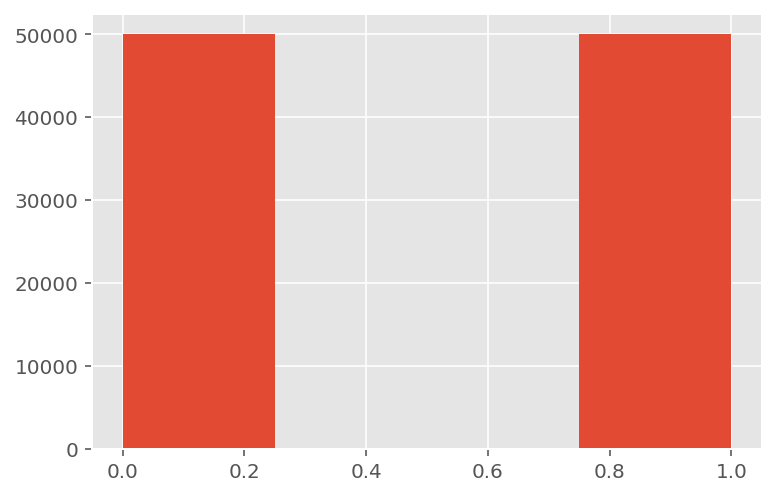

In [10]:
plt.hist(y,bins=4)

### 1.3 Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice. 

### Though the original dataset is 1.6 million, I used 200 thousand of them because most of my RNN models can't run under a fast cuDNN implementation since it has strict requirement(The first model of LSTM and GRU, they can be trained fast because of using cuDNN implementation), which makes the training a long period. Besides, I think 200 thousand is big enough for me to safely use 80-20 traning and testing split and also because of this totally balanced dataset.

### Besides, to improve computational efficiency, I do not use K-fold here though I think it is good idea to evaluate my model.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=30)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(80000, 35)
(20000, 35)
(80000,)
(20000,)


## 2. Modeling (6 points total)
- [3 points] Investigate at least two different recurrent network architectures (perhaps LSTM and GRU). Be sure to use an embedding layer (pre-trained, from scratch, OR both). Adjust hyper-parameters of the networks as needed to improve generalization performance (train a total of at least four models). Discuss the performance of each network and compare them.
- [1 points] Using the best RNN parameters and architecture, add a second recurrent chain to your RNN. The input to the second chain should be the output sequence of the first chain. Visualize the performance of training and validation sets versus the training iterations. 
- [2 points] Use the method of train/test splitting and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the RNNs you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior. 

### During the training, I use early stopping by monitoring the val_loss with patience=10 and reducing the learning rate by monitoring val_loss with patience 5 in order to prevent overfitting.

In [12]:
def plot_metrics(history,label):
    metrics = ['loss', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        # plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Train ' + label)
        plt.plot(history.epoch, history.history['val_'+metric],linestyle="--", label='Val ' + label)
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric != 'loss':
            plt.ylim([0,1])
        plt.title('{}'.format(metric))
        plt.legend()
        plt.show()

def evaluate_model(model,X_train,y_train,X_test,y_test,model_name,epochs=100,batch_size=128,verbose=1): 
    h = model.fit(X_train,
        y_train, 
        epochs=epochs, 
        verbose=verbose,
        batch_size=batch_size,
        shuffle=True,
        callbacks=[EarlyStopping(monitor = 'val_loss', patience = 6),ReduceLROnPlateau(monitor='val_loss', patience=3)],
        validation_data=(X_test, y_test)
    )
    plot_metrics(h,model_name)
    # now lets see how well the model performed
    yscore = model.predict(X_test).flatten()
    yhat = np.around(yscore)
    acc = mt.accuracy_score(y_test,yhat)
    fp,tp,_ = mt.roc_curve(y_test,yscore)
    f1_score = mt.f1_score(y_test,yhat)
    # cm = mt.confusion_matrix(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot = True,fmt = '.2f')
    plt.title('{}: acc={:.4f}, f1={:.4f}'.format(model_name,acc,f1_score))
    plt.show()
    print(classification_report(y_test,yhat))
    return {'history':h,'cm':cm,'acc':acc,'fp':fp, 'tp':tp, 'f1':f1_score}

In [13]:
def compare_model(model1_eval,model2_eval,model1_name,model2_name):
    fp1 = model1_eval['fp']
    tp1 = model1_eval['tp']
    fp2 = model2_eval['fp']
    tp2 = model2_eval['tp']
    plt.plot(fp1, tp1, label='{} ROC (AUC {:.3f})'.format(model1_name,auc(fp1,tp1)) , linewidth=2)
    plt.plot(fp2, tp2, label='{} ROC (AUC {:.3f})'.format(model2_name,auc(fp2,tp2)), linewidth=2, linestyle='--')
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid(True)
    ax = plt.gca()
    # ax.set_aspect('equal')
    plt.legend(loc='best')
    plt.show()

    plt.figure(figsize=(15,5))
    acc1 = model1_eval['acc']
    acc2 = model2_eval['acc']
    f1_1 = model1_eval['f1']
    f1_2 = model2_eval['f1']
    cm1 = model1_eval['cm']
    # cm1 = cm1/np.sum(cm1,axis=1)[:,np.newaxis]
    cm2 = model2_eval['cm']
    # cm2 = cm2/np.sum(cm2,axis=1)[:,np.newaxis]

    plt.subplot(1,2,1)
    sns.heatmap(cm1, annot=True, fmt='.2f')
    plt.title('{}: acc={:.4f}, f1={:.4f}'.format(model1_name,acc1,f1_1))

    plt.subplot(1,2,2)
    sns.heatmap(cm2, annot=True, fmt='.2f')
    plt.title('{}: acc={:.4f}, f1={:.4f}'.format(model2_name,acc2,f1_2))

    plt.show()

    d = np.abs(acc1-acc2)
    v = acc1*(1-acc1)/X_test.shape[0] + acc2*(1-acc2)/X_test.shape[0]
    print('The difference on accuracy of {} and {} is {},{} '.format(model1_name,model2_name,d-1.96*np.sqrt(v),d+1.96*np.sqrt(v)))

    d = np.abs(f1_1-f1_2)
    v = f1_1*(1-f1_1)/X_test.shape[0] + f1_2*(1-f1_2)/X_test.shape[0]
    print('The difference on f1 score of {} and {} is {},{} '.format(model1_name,model2_name,d-1.96*np.sqrt(v),d+1.96*np.sqrt(v)))

### I used an pre-trained GloVe embedding

In [14]:
%%time
EMBED_SIZE = 300
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('large_data/glove/glove.6B.300d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])


# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

Found 400000 word vectors.
Embedding Shape: (66641, 300) 
 Total words found: 33598 
 Percentage: 50.41641031797242
CPU times: user 12.8 s, sys: 341 ms, total: 13.2 s
Wall time: 13 s


### This is a RNN model using LSTM, which is called LSTM1

In [15]:
NUM_CLASSES = 1
rnn1 = Sequential(name='LSTM1')
rnn1.add(embedding_layer)
rnn1.add(LSTM(16))
rnn1.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn1.compile(loss='mean_squared_error', 
              optimizer='RMSprop', 
              metrics=['accuracy'])
rnn1.summary(line_length=90)

Metal device set to: Apple M1 Max
Model: "LSTM1"
__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
embedding (Embedding)                   (None, 35, 300)                     19992300      
__________________________________________________________________________________________
lstm (LSTM)                             (None, 16)                          20288         
__________________________________________________________________________________________
dense (Dense)                           (None, 1)                           17            
Total params: 20,012,605
Trainable params: 20,305
Non-trainable params: 19,992,300
__________________________________________________________________________________________


2021-11-15 20:52:38.546019: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-15 20:52:38.546126: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2021-11-15 20:52:38.708319: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-15 20:52:38.708482: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-11-15 20:52:39.082998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-15 20:52:39.151196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-15 20:52:39.250996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


79/80 [============================>.] - ETA: 0s - loss: 0.2087 - accuracy: 0.6757

2021-11-15 20:52:42.073801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-15 20:52:42.102017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - 4s 36ms/step - loss: 0.2084 - accuracy: 0.6761 - val_loss: 0.1899 - val_accuracy: 0.7168
Epoch 2/100
80/80 [==============================] - 3s 33ms/step - loss: 0.1873 - accuracy: 0.7180 - val_loss: 0.1828 - val_accuracy: 0.7269
Epoch 3/100
80/80 [==============================] - 3s 33ms/step - loss: 0.1830 - accuracy: 0.7234 - val_loss: 0.1799 - val_accuracy: 0.7321
Epoch 4/100
80/80 [==============================] - 3s 34ms/step - loss: 0.1806 - accuracy: 0.7286 - val_loss: 0.1782 - val_accuracy: 0.7329
Epoch 5/100
80/80 [==============================] - 3s 33ms/step - loss: 0.1786 - accuracy: 0.7327 - val_loss: 0.1770 - val_accuracy: 0.7338
Epoch 6/100
80/80 [==============================] - 3s 34ms/step - loss: 0.1772 - accuracy: 0.7348 - val_loss: 0.1757 - val_accuracy: 0.7369
Epoch 7/100
80/80 [==============================] - 3s 34ms/step - loss: 0.1756 - accuracy: 0.7378 - val_loss: 0.1749 - val_accuracy: 0.7384
Epoch 8/100
80/80 

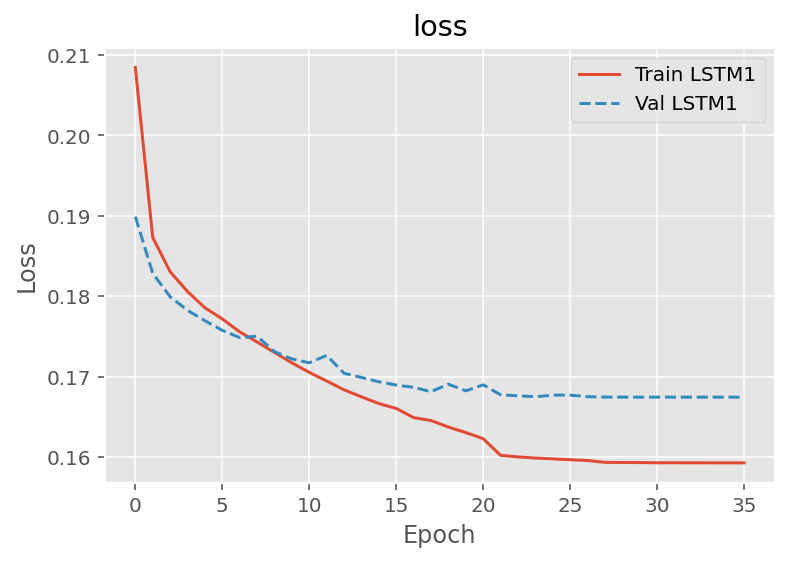

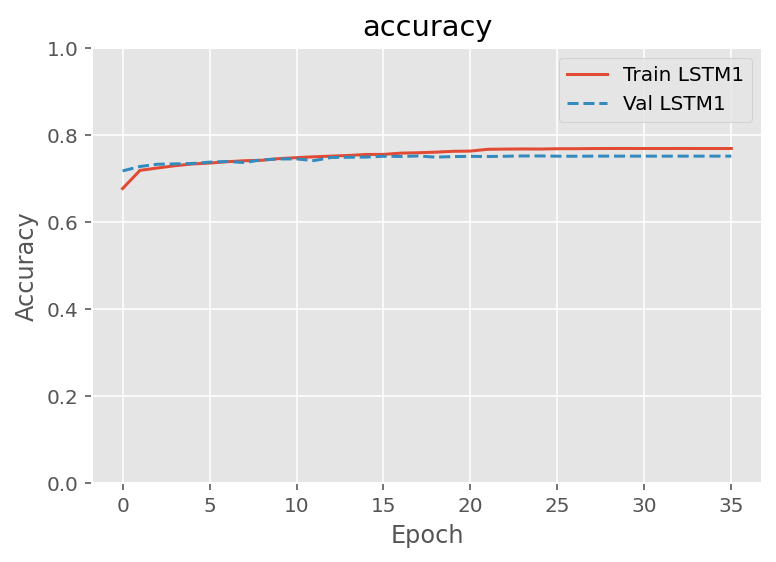

2021-11-15 20:54:17.152549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-15 20:54:17.175002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


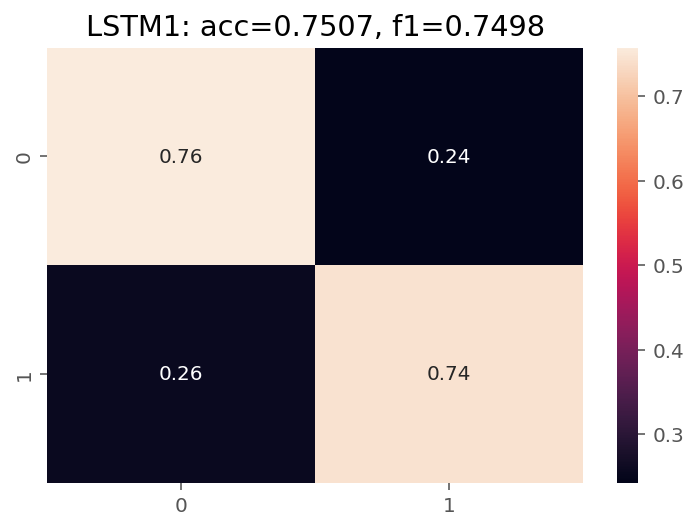

              precision    recall  f1-score   support

           0       0.75      0.76      0.75      9958
           1       0.76      0.74      0.75     10042

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000

CPU times: user 57.6 s, sys: 36.1 s, total: 1min 33s
Wall time: 1min 42s


In [16]:
%%time
rnn1_eval = evaluate_model(rnn1,X_train,y_train,X_test,y_test,rnn1.name,batch_size=1000,verbose=1)

### This is a RNN model using Bidirectional LSTM with dropouts and loss function and optimizer altered, which is called LSTM2

In [17]:
rnn1.save("lstm.h5")

### This is a RNN model using GRU, which is called GRU1

In [18]:
rnn3 = Sequential(name='GRU1')
rnn3.add(embedding_layer)
rnn3.add(GRU(16))
rnn3.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn3.compile(loss='mean_squared_error', 
              optimizer='RMSprop', 
              metrics=['accuracy'])
rnn3.summary(line_length=90)

Model: "GRU1"
__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
embedding (Embedding)                   (None, 35, 300)                     19992300      
__________________________________________________________________________________________
gru (GRU)                               (None, 16)                          15264         
__________________________________________________________________________________________
dense_1 (Dense)                         (None, 1)                           17            
Total params: 20,007,581
Trainable params: 15,281
Non-trainable params: 19,992,300
__________________________________________________________________________________________


Epoch 1/100


2021-11-15 20:54:21.177130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-15 20:54:21.239003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-15 20:54:21.312338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - ETA: 0s - loss: 0.2139 - accuracy: 0.6658

2021-11-15 20:54:23.216906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-15 20:54:23.248363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - 3s 25ms/step - loss: 0.2139 - accuracy: 0.6658 - val_loss: 0.1913 - val_accuracy: 0.7084
Epoch 2/100
80/80 [==============================] - 2s 23ms/step - loss: 0.1875 - accuracy: 0.7162 - val_loss: 0.1831 - val_accuracy: 0.7265
Epoch 3/100
80/80 [==============================] - 2s 22ms/step - loss: 0.1837 - accuracy: 0.7234 - val_loss: 0.1813 - val_accuracy: 0.7269
Epoch 4/100
80/80 [==============================] - 2s 22ms/step - loss: 0.1822 - accuracy: 0.7268 - val_loss: 0.1826 - val_accuracy: 0.7273
Epoch 5/100
80/80 [==============================] - 2s 22ms/step - loss: 0.1813 - accuracy: 0.7301 - val_loss: 0.1804 - val_accuracy: 0.7269
Epoch 6/100
80/80 [==============================] - 2s 23ms/step - loss: 0.1806 - accuracy: 0.7302 - val_loss: 0.1798 - val_accuracy: 0.7289
Epoch 7/100
80/80 [==============================] - 2s 22ms/step - loss: 0.1801 - accuracy: 0.7319 - val_loss: 0.1798 - val_accuracy: 0.7299
Epoch 8/100
80/80 

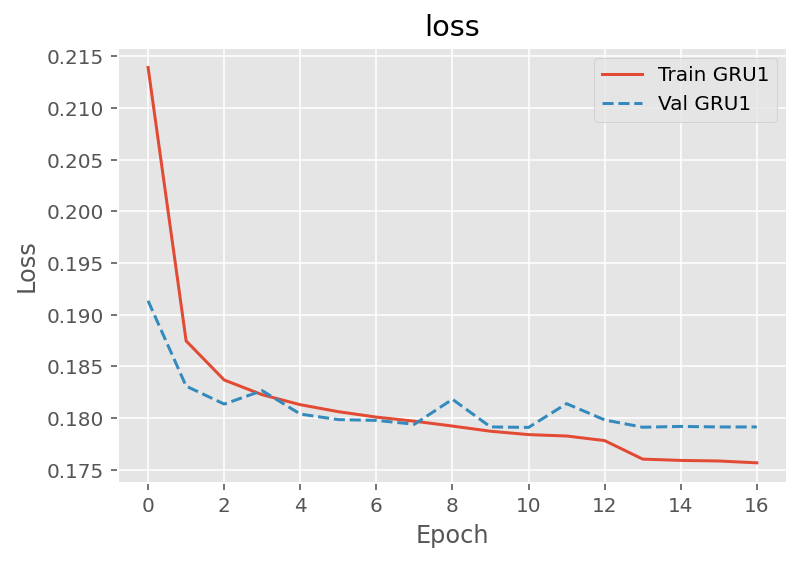

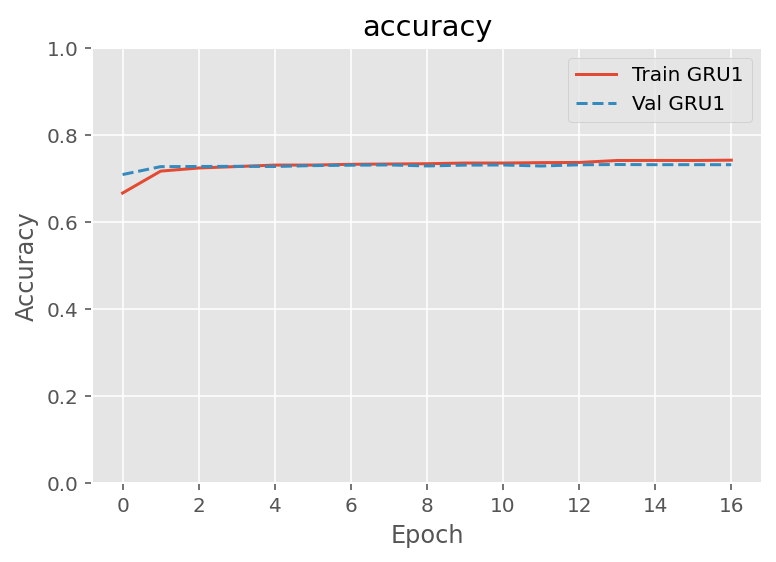

2021-11-15 20:54:52.468872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-15 20:54:52.488166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


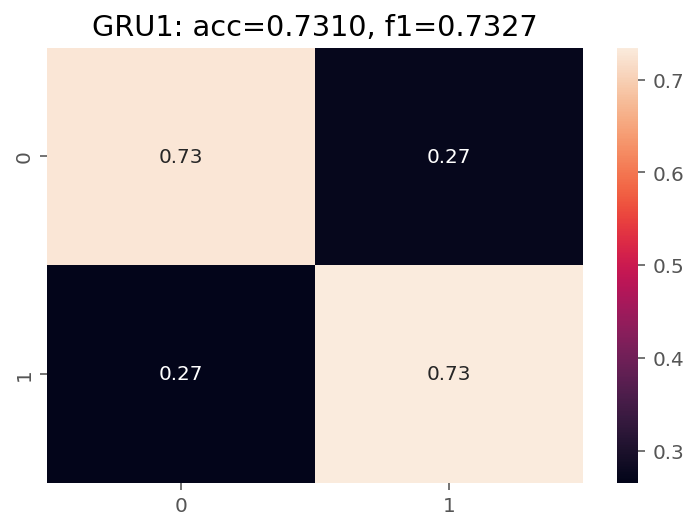

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      9958
           1       0.73      0.73      0.73     10042

    accuracy                           0.73     20000
   macro avg       0.73      0.73      0.73     20000
weighted avg       0.73      0.73      0.73     20000

CPU times: user 28.5 s, sys: 18 s, total: 46.5 s
Wall time: 36.2 s


In [19]:
%%time
rnn3_eval = evaluate_model(rnn3,X_train,y_train,X_test,y_test,rnn3.name,batch_size=1000,verbose=1)

### This is a RNN model using Bidirectional GRU with dropouts and loss function and optimzer altered, which is called GRU2.

In [20]:
rnn3.save("gru.h5")

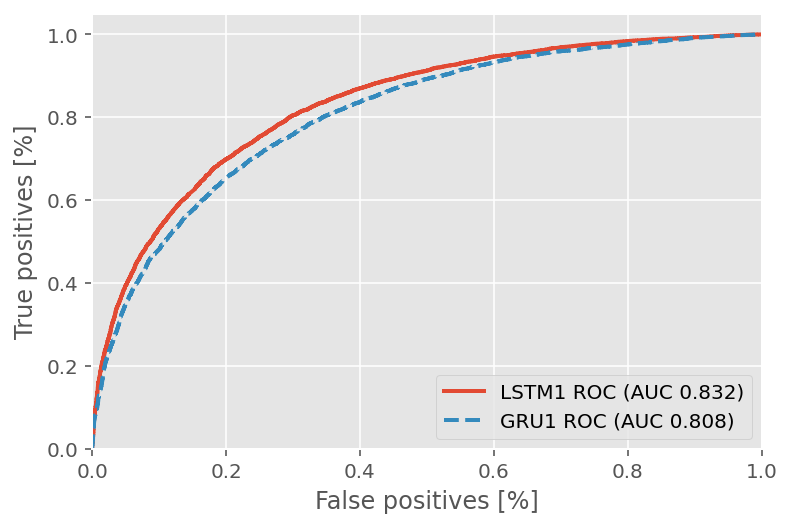

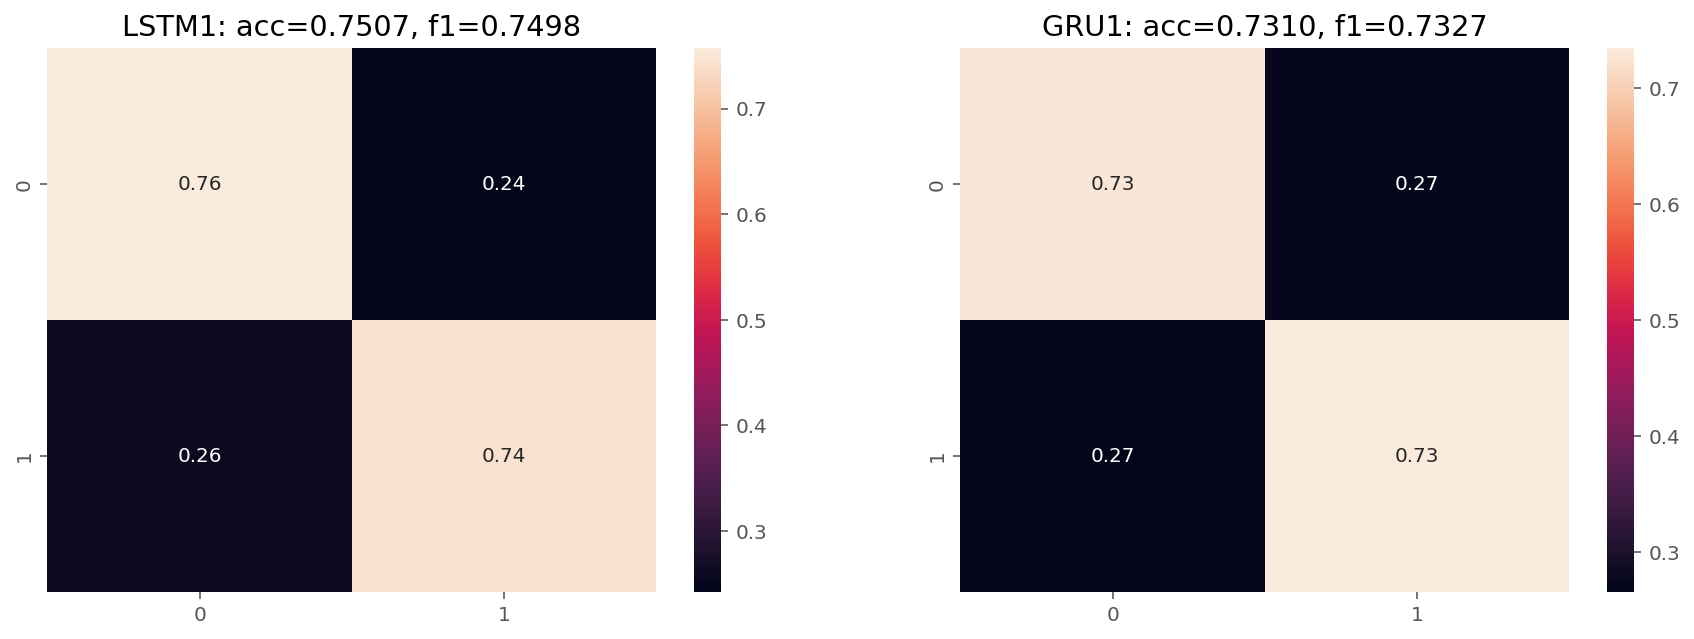

The difference on accuracy of LSTM1 and GRU1 is 0.011114075646687822,0.02828592435331228 
The difference on f1 score of LSTM1 and GRU1 is 0.008505362822895391,0.02566899158045742 


In [21]:
compare_model(rnn1_eval,rnn3_eval,rnn1.name,rnn3.name)

### Based on the roc curve, accuracy and F1 score comparison, the model GRU2 is better than GRU1. With 95% confidence, the GRU2 is also better.

### With 95% confidence, the LSTM2 and GRU2 is not different statistically. But I like the GRU2, it seems slightly better on both accuracy and F1 score.

### 2.2 Using the best RNN parameters and architecture, add a second recurrent chain to your RNN. The input to the second chain should be the output sequence of the first chain. Visualize the performance of training and validation sets versus the training iterations. 

### Since in this case, the LSTM and GRU is not different, I use GRU2 as my best model. Then I added another GRU on the previous model GRU2 and formed the model GRU3

### With 95% confidence, the two models are statistically different and the GRU2 seems better. Based on the accuracy, F1 score and ROC curve, the model GRU2 also looks better than GRU3.

## Exceptional Work (1 points total)
- You have free reign to provide additional analyses.
- One idea (required for 7000 level students to do one of these options):
    - Option 1: Use dimensionality reduction (choose an appropriate method from this list: t-SNE, SVD, PCA, or UMAP) to visualize the word embeddings of a subset of words in your vocabulary that you expect to have an analogy that can be captured by the embedding. Try to interpret if an analogy exists, show the vectors that support/refute the analogy, and interpret your findings. 
    - Options 2: Use the ConceptNet Numberbatch embedding and compare to GloVe. Which method is better for your specific application? 
- Another Idea (NOT required): Try to create a RNN for generating novel text. 

### I used the ConceptNet Numberbatch embedding and compare to GloVe

In [22]:
%%time
EMBED_SIZE = 300
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('large_data/numberbatch-en-19.08.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])


# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

Found 516783 word vectors.
Embedding Shape: (66641, 300) 
 Total words found: 30516 
 Percentage: 45.79162977746432
CPU times: user 16.4 s, sys: 399 ms, total: 16.8 s
Wall time: 16.7 s


In [23]:
rnn6 = Sequential(name='GRU4')
rnn6.add(embedding_layer)
rnn6.add(Dropout(0.5))
rnn6.add(GRU(16))
rnn6.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn6.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
rnn6.summary(line_length=90)

Model: "GRU4"
__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
embedding_1 (Embedding)                 (None, 35, 300)                     19992300      
__________________________________________________________________________________________
dropout (Dropout)                       (None, 35, 300)                     0             
__________________________________________________________________________________________
gru_1 (GRU)                             (None, 16)                          15264         
__________________________________________________________________________________________
dense_2 (Dense)                         (None, 1)                           17            
Total params: 20,007,581
Trainable params: 15,281
Non-trainable params: 19,992,300
____________________________________________________________________________________

Epoch 1/100


2021-11-15 20:55:14.567745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-15 20:55:14.630596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-15 20:55:14.772795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


79/80 [============================>.] - ETA: 0s - loss: 0.6707 - accuracy: 0.6165

2021-11-15 20:55:17.043787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-15 20:55:17.073325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - 3s 29ms/step - loss: 0.6700 - accuracy: 0.6172 - val_loss: 0.6043 - val_accuracy: 0.7016
Epoch 2/100
80/80 [==============================] - 2s 24ms/step - loss: 0.5784 - accuracy: 0.7000 - val_loss: 0.5348 - val_accuracy: 0.7461
Epoch 3/100
80/80 [==============================] - 2s 24ms/step - loss: 0.5630 - accuracy: 0.7134 - val_loss: 0.5290 - val_accuracy: 0.7483
Epoch 4/100
80/80 [==============================] - 2s 24ms/step - loss: 0.5593 - accuracy: 0.7171 - val_loss: 0.5227 - val_accuracy: 0.7512
Epoch 5/100
80/80 [==============================] - 2s 25ms/step - loss: 0.5550 - accuracy: 0.7163 - val_loss: 0.5172 - val_accuracy: 0.7530
Epoch 6/100
80/80 [==============================] - 2s 24ms/step - loss: 0.5540 - accuracy: 0.7181 - val_loss: 0.5149 - val_accuracy: 0.7534
Epoch 7/100
80/80 [==============================] - 2s 24ms/step - loss: 0.5517 - accuracy: 0.7184 - val_loss: 0.5149 - val_accuracy: 0.7525
Epoch 8/100
80/80 

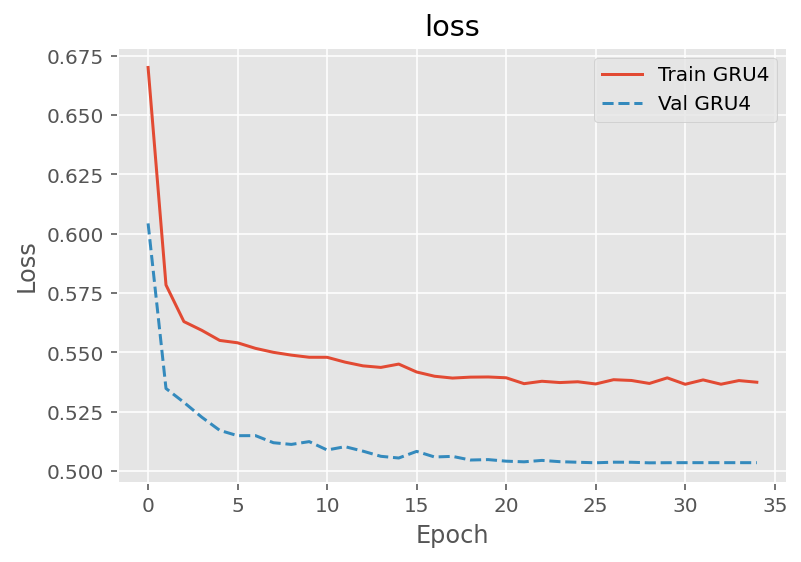

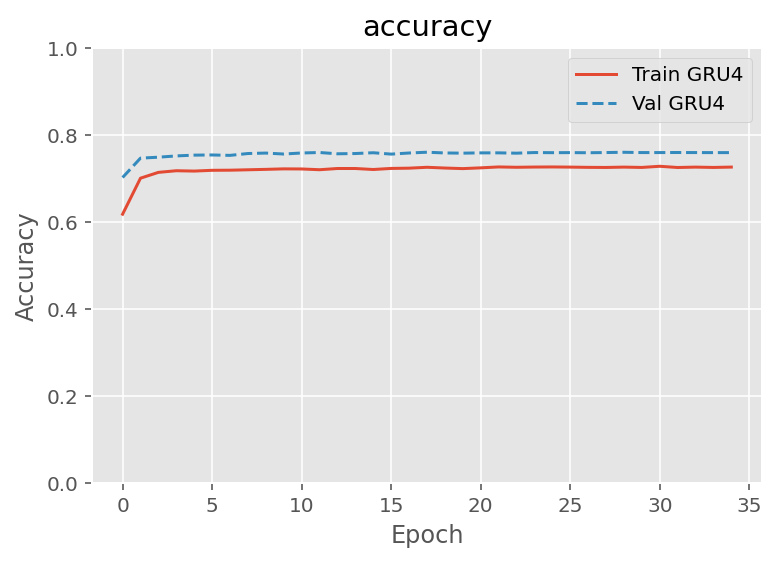

2021-11-15 20:56:23.555015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-15 20:56:23.575091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


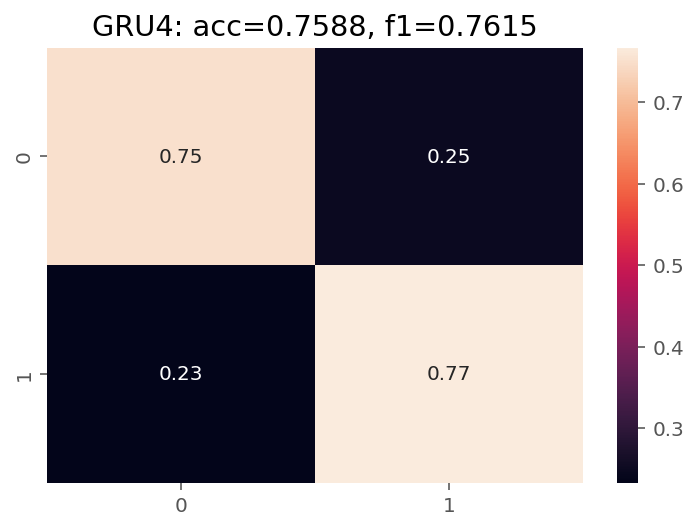

              precision    recall  f1-score   support

           0       0.76      0.75      0.76      9958
           1       0.76      0.77      0.76     10042

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

CPU times: user 56.3 s, sys: 38.3 s, total: 1min 34s
Wall time: 1min 12s


In [24]:
%%time
rnn6_eval = evaluate_model(rnn6,X_train,y_train,X_test,y_test,rnn6.name,batch_size=1000,verbose=1)

In [25]:
rnn6.save("gru_conceptNet.h5")

In [26]:
rnn7 = Sequential(name='LSTM4')
rnn7.add(embedding_layer)
rnn7.add(Dropout(0.5))
rnn7.add(LSTM(16))
rnn7.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn7.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
rnn7.summary(line_length=90)

Model: "LSTM4"
__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
embedding_1 (Embedding)                 (None, 35, 300)                     19992300      
__________________________________________________________________________________________
dropout_1 (Dropout)                     (None, 35, 300)                     0             
__________________________________________________________________________________________
lstm_1 (LSTM)                           (None, 16)                          20288         
__________________________________________________________________________________________
dense_3 (Dense)                         (None, 1)                           17            
Total params: 20,012,605
Trainable params: 20,305
Non-trainable params: 19,992,300
___________________________________________________________________________________

Epoch 1/100


2021-11-15 20:56:27.084862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-15 20:56:27.154010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-15 20:56:27.233719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


79/80 [============================>.] - ETA: 0s - loss: 0.6509 - accuracy: 0.6432

2021-11-15 20:56:30.055452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-15 20:56:30.086597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - 4s 38ms/step - loss: 0.6502 - accuracy: 0.6441 - val_loss: 0.5834 - val_accuracy: 0.7276
Epoch 2/100
80/80 [==============================] - 3s 36ms/step - loss: 0.5799 - accuracy: 0.7048 - val_loss: 0.5412 - val_accuracy: 0.7458
Epoch 3/100
80/80 [==============================] - 3s 36ms/step - loss: 0.5602 - accuracy: 0.7140 - val_loss: 0.5255 - val_accuracy: 0.7486
Epoch 4/100
80/80 [==============================] - 3s 36ms/step - loss: 0.5563 - accuracy: 0.7133 - val_loss: 0.5206 - val_accuracy: 0.7516
Epoch 5/100
80/80 [==============================] - 3s 35ms/step - loss: 0.5524 - accuracy: 0.7159 - val_loss: 0.5137 - val_accuracy: 0.7537
Epoch 6/100
80/80 [==============================] - 3s 36ms/step - loss: 0.5489 - accuracy: 0.7156 - val_loss: 0.5127 - val_accuracy: 0.7552
Epoch 7/100
80/80 [==============================] - 3s 36ms/step - loss: 0.5454 - accuracy: 0.7198 - val_loss: 0.5092 - val_accuracy: 0.7566
Epoch 8/100
80/80 

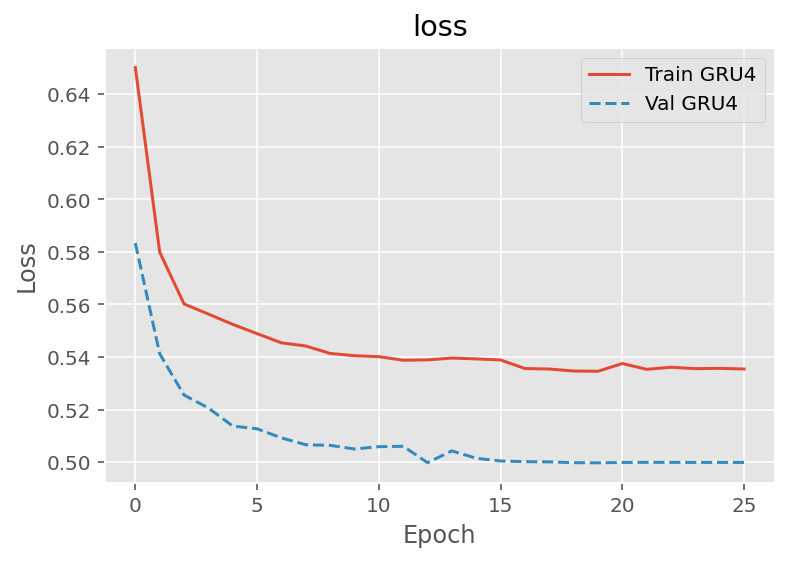

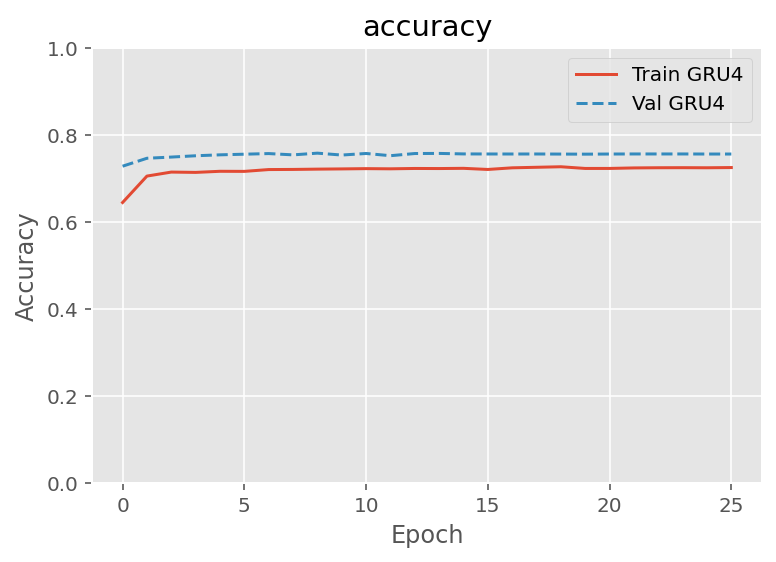

2021-11-15 20:57:41.870051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-15 20:57:41.891503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


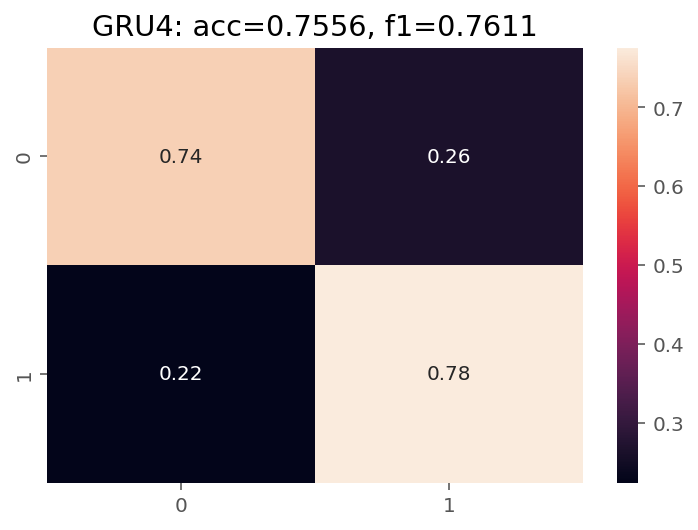

              precision    recall  f1-score   support

           0       0.76      0.74      0.75      9958
           1       0.75      0.78      0.76     10042

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

CPU times: user 43.1 s, sys: 28.3 s, total: 1min 11s
Wall time: 1min 18s


In [27]:
%%time
rnn7_eval = evaluate_model(rnn7,X_train,y_train,X_test,y_test,rnn6.name,batch_size=1000,verbose=1)

In [28]:
rnn7.save("lstm_conceptNet.h5")

### With 95% confidence, the two models are not different statistically. However, I prefer the the model GRU2(with GloVe embedding), because of slightly higher F1 score and accuracy.

In [29]:
# compare_model(rnn6_eval,rnn4_eval,rnn6.name,rnn4.name)

In [30]:
from keras.models import load_model

rnn1_load = load_model("lstm_conceptNet.h5")
rnn1_load.summary(line_length=90)

Model: "LSTM4"
__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
embedding_1 (Embedding)                 (None, 35, 300)                     19992300      
__________________________________________________________________________________________
dropout_1 (Dropout)                     (None, 35, 300)                     0             
__________________________________________________________________________________________
lstm_1 (LSTM)                           (None, 16)                          20288         
__________________________________________________________________________________________
dense_3 (Dense)                         (None, 1)                           17            
Total params: 20,012,605
Trainable params: 20,305
Non-trainable params: 19,992,300
___________________________________________________________________________________

Epoch 1/100


2021-11-15 20:57:45.791554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-15 20:57:45.858071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-15 20:57:45.946574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


79/80 [============================>.] - ETA: 0s - loss: 0.5366 - accuracy: 0.7249

2021-11-15 20:57:48.791001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-15 20:57:48.821448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - 3s 38ms/step - loss: 0.5367 - accuracy: 0.7248 - val_loss: 0.4999 - val_accuracy: 0.7556
Epoch 2/100
80/80 [==============================] - 3s 36ms/step - loss: 0.5357 - accuracy: 0.7233 - val_loss: 0.4999 - val_accuracy: 0.7556
Epoch 3/100
80/80 [==============================] - 3s 36ms/step - loss: 0.5345 - accuracy: 0.7256 - val_loss: 0.4999 - val_accuracy: 0.7556
Epoch 4/100
80/80 [==============================] - 3s 36ms/step - loss: 0.5348 - accuracy: 0.7245 - val_loss: 0.4999 - val_accuracy: 0.7556
Epoch 5/100
80/80 [==============================] - 3s 36ms/step - loss: 0.5359 - accuracy: 0.7228 - val_loss: 0.4999 - val_accuracy: 0.7556
Epoch 6/100
80/80 [==============================] - 3s 35ms/step - loss: 0.5350 - accuracy: 0.7238 - val_loss: 0.4999 - val_accuracy: 0.7556
Epoch 7/100
80/80 [==============================] - 3s 36ms/step - loss: 0.5373 - accuracy: 0.7243 - val_loss: 0.4999 - val_accuracy: 0.7556
Epoch 8/100
80/80 

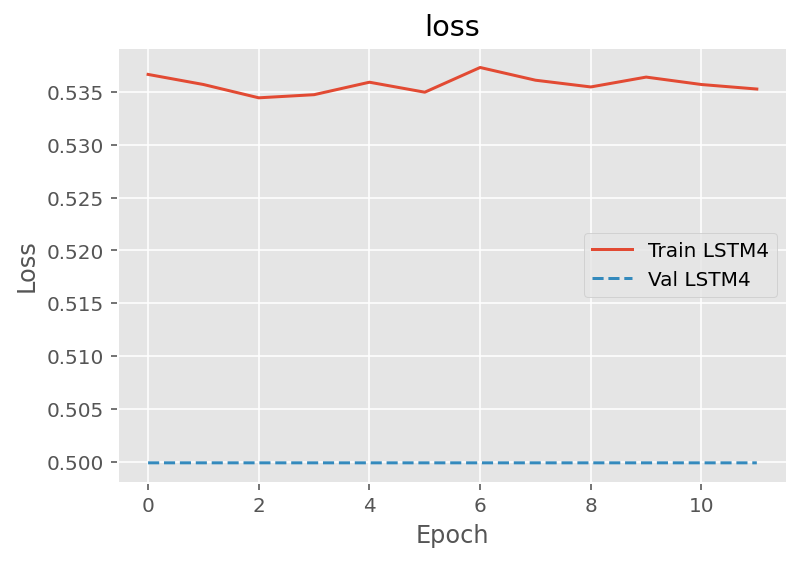

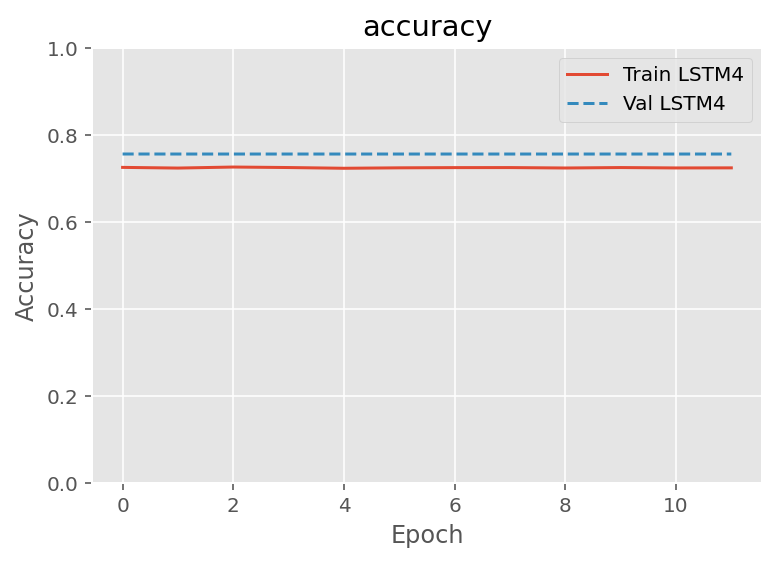

2021-11-15 20:58:20.817397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-15 20:58:20.839903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


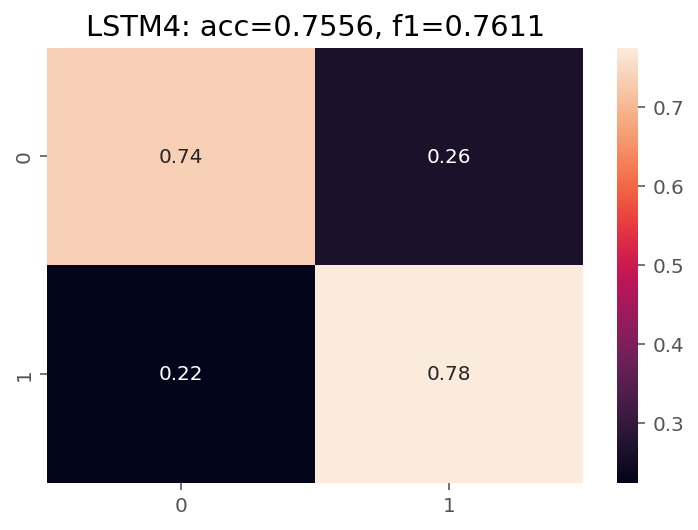

              precision    recall  f1-score   support

           0       0.76      0.74      0.75      9958
           1       0.75      0.78      0.76     10042

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

CPU times: user 21.6 s, sys: 13.1 s, total: 34.7 s
Wall time: 38.7 s


In [31]:
%%time
rnn1_load_eval = evaluate_model(rnn1_load,X_train,y_train,X_test,y_test,rnn1_load.name,batch_size=1000,verbose=1)

In [32]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [40]:
# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

testString = ["msl class sucks","have a good day"]
print(testString)
sequence1 = tokenizer.texts_to_sequences(testString)
print(sequence1)

testX_one = pad_sequences(sequence1,maxlen=35)
testX_one.shape


['msl class sucks', 'have a good day']
[[316, 160], [2, 4]]


(2, 35)

In [37]:
rnn2_load = load_model("lstm_conceptNet.h5")
rnn2_load.summary(line_length=90)
rnn2_load.fit(
    np.array(testX_one),
    np.array([1]),
    epochs=10,
    batch_size = 10
)


#     h = model.fit(X_train,
#         y_train, 
#         epochs=epochs, 
#         verbose=verbose,
#         batch_size=batch_size,
#         shuffle=True,
#         callbacks=[EarlyStopping(monitor = 'val_loss', patience = 6),ReduceLROnPlateau(monitor='val_loss', patience=3)],
#         validation_data=(X_test, y_test)
#     )

Model: "LSTM4"
__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
embedding_1 (Embedding)                 (None, 35, 300)                     19992300      
__________________________________________________________________________________________
dropout_1 (Dropout)                     (None, 35, 300)                     0             
__________________________________________________________________________________________
lstm_1 (LSTM)                           (None, 16)                          20288         
__________________________________________________________________________________________
dense_3 (Dense)                         (None, 1)                           17            
Total params: 20,012,605
Trainable params: 20,305
Non-trainable params: 19,992,300
___________________________________________________________________________________

2021-11-15 22:18:47.225863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-15 22:18:47.463774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-15 22:18:47.924695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 3.1633 - accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 17ms/step - loss: 2.7470 - accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 3.3107 - accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 17ms/step - loss: 2.3118 - accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 17ms/step - loss: 2.5100 - accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 18ms/step - loss: 3.2748 - accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 18ms/step - loss: 3.0703 - accuracy: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 17ms/step - loss: 2.0345 - accuracy: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 17ms/step - loss: 2.5132 - accuracy: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 16ms/step - loss: 1.8829 - accuracy: 0.0000e+00


In [35]:
predScore = rnn1_load.predict(testX_one).flatten()
print(predScore)
predResult = np.around(predScore)[0]
predResult

[0.05766848]


0.0

In [43]:
import coremltools
rnn2_load = load_model("lstm_conceptNet.h5")
coreml_model = coremltools.converters.keras.convert(rnn2_load)
coreml_model.save('lstm_conceptNet.mlmodel')

rnn3_load = load_model("gru_conceptNet.h5")
coreml_model = coremltools.converters.keras.convert(rnn3_load)
coreml_model.save('gru_conceptNet.mlmodel')



/Users/Amor/miniforge3/envs/msl/lib/python3.9/site-packages/coremltools/models/_deprecation.py:29: FutureWarning: Function "convert" is deprecated and will be removed in 6.0.
  warnings.warn(msg, category=FutureWarning)


AttributeError: module 'keras.layers.normalization' has no attribute 'BatchNormalization'